In [17]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import os
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from keras import layers
from keras import models
from keras import metrics
from sklearn.model_selection import KFold
from scipy.optimize import curve_fit as cf

In [2]:
display("Pillow Version", PIL.__version__)

'Pillow Version'

'7.2.0'

In [3]:
# load the image
img = load_img('/Users/mjcuf/Documents/StatsProject/ImageData/TrainingData/Matthew_cufari_17_1.jpg')#, target_size=(750,1300,3))
print("Orignal:" ,type(img))

# convert to numpy array
img_array = img_to_array(img)
img_array /= 255.

print("NumPy array info:") 
print(type(img_array))    

print("type:",img_array.dtype)
print("shape:",img_array.shape)
# convert back to image

img_pil = array_to_img(img_array)
img_pil.save("test.png")


Orignal: <class 'PIL.JpegImagePlugin.JpegImageFile'>
NumPy array info:
<class 'numpy.ndarray'>
type: float32
shape: (2316, 3088, 3)


In [4]:
def load_data(directory):
    trainDir = os.path.join(directory, "trainingData\\")
    testDir = os.path.join(directory, "testingData\\")
    train = np.empty((len(os.listdir(trainDir)), 512, 512, 3))
    test =  np.empty((len(os.listdir(testDir)), 512, 512, 3))
    train_labels = np.empty(len(os.listdir(trainDir)),dtype=int)
    #print((os.listdir(trainDir)))
    test_labels = np.empty(len(os.listdir(testDir)),dtype=int)
    train, train_labels = getData(trainDir, train, train_labels)
    test, test_labels = getData(testDir, test, test_labels)
    return (train[:-1], train_labels[:-1]), (test[:-1], test_labels[:-1])
def getData(directory, array, labels):
    i = 0
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            
            path = os.path.join(directory, filename)
            #print(path)
            img = load_img(path, target_size=(512,512, 3))
            #print("Orignal:" ,type(img))

            # convert to numpy array
            img_array = img_to_array(img)
            img_array /= 255.
            array[i] = img_array
            labels[i] = int(path[-5])
            i += 1
        else:
            continue
    return array, labels
def load_labels(directory):
    trainDir = os.path.join(directory, "trainingData\\")
    testDir = os.path.join(directory, "testingData\\")
    trainLabels = np.empty(len(os.listdir(trainDir)),dtype=int)
    #print((os.listdir(trainDir)))
    testLabels = np.empty(len(os.listdir(testDir)),dtype=int)
    trainLabels = getLabels(trainDir, trainLabels)
    testLabels = getLabels(testDir, testLabels)
    return trainLabels[:-1], testLabels[:-1]
def getLabels(directory, labels):
  
    i = 0
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            
            labels[i] = int(filename[-5])
            print(labels[i])
            i += 1
        else:
            continue
    return labels

In [5]:
def buildModel():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(512, 512, 3)))
    model.add(layers.MaxPooling2D((3,3)))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((3,3)))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((3,3)))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((3,3)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [6]:
model = buildModel()
(train_data, train_labels), (test_data, test_labels) = load_data(r"\Users\mjcuf\Documents\StatsProject\ImageData\\")
kfold = KFold(5, shuffle=True)
data = np.concatenate((train_data,test_data))
labels = np.concatenate((train_labels, test_labels))
#train_labels, test_label = load_labels(r"\Users\mjcuf\Documents\StatsProject\ImageData\\")

In [7]:
model_histories = []
model_results = []
i = 0
for train_index, test_index in kfold.split(data):
    print(i)
    x_train =  data[train_index]
    x_test  =  data[test_index]
    y_train =  labels[train_index]
    y_test  =  labels[test_index]
    model = buildModel()
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=[metrics.binary_accuracy])
    history = model.fit(x_train, y_train, epochs=25, batch_size=16, shuffle=1, verbose=0)
    model_histories.append(history)
    model_results.append(model.evaluate(x_test,y_test))
    i+= 1

0
29/29 [==============================] - 1s 22ms/step
1
29/29 [==============================] - 0s 5ms/step
2
29/29 [==============================] - 0s 5ms/step
3
29/29 [==============================] - 0s 5ms/step
4
29/29 [==============================] - 0s 5ms/step


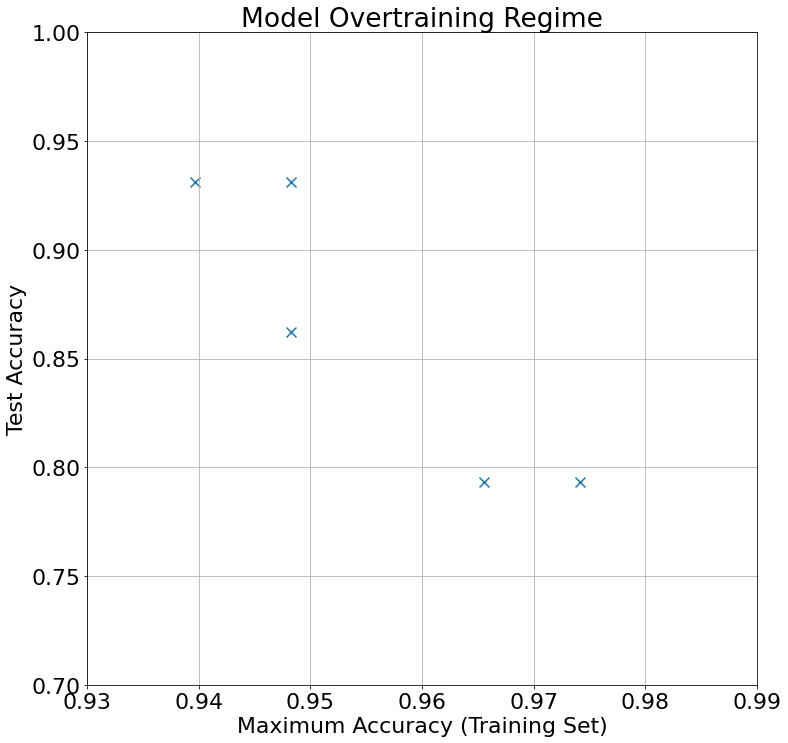

In [10]:
max_acc = []
model_acc = []
for i, history in enumerate(model_histories):
    max_acc.append(np.max(history.history['binary_accuracy']))
    model_acc.append(model_results[i][1])
plt.rcParams.update({"font.size":"22"})

plt.figure(figsize=(12,12))
plt.title("Model Overtraining Regime")
plt.scatter(max_acc, model_acc, marker='x', s=100)
plt.xlim(0.93, 0.99)
plt.ylim(0.70, 1.0)
plt.xlabel("Maximum Accuracy (Training Set)")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.show()

In [79]:
limit_model_histories = []
limit_model_results = []
i = 0
for train_index, test_index in kfold.split(data):
    print(i)
    x_train =  data[train_index]
    x_test  =  data[test_index]
    y_train =  labels[train_index]
    y_test  =  labels[test_index]
    model = buildModel()
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=[metrics.binary_accuracy])
    history = model.fit(x_train, y_train, epochs=10, batch_size=16, shuffle=1, verbose=0)
    limit_model_histories.append(history)
    limit_model_results.append(model.evaluate(x_test,y_test))
    i+= 1

0
29/29 [==============================] - 0s 5ms/step
1
29/29 [==============================] - 0s 5ms/step
2
29/29 [==============================] - 0s 5ms/step
3
29/29 [==============================] - 0s 5ms/step
4
29/29 [==============================] - 0s 5ms/step


In [130]:
max_acc = []
model_acc = []
limit_model_acc = []
limit_max_acc = []
for i, history in enumerate(model_histories):
    max_acc.append(np.max(history.history['binary_accuracy'])*100)
    limit_max_acc.append(np.max(limit_model_histories[i].history['binary_accuracy'])*100)
    limit_model_acc.append(limit_model_results[i][1]*100)
    model_acc.append(model_results[i][1]*100)
x_data = np.concatenate((limit_max_acc,max_acc))
y_data = np.concatenate((limit_model_acc, model_acc))
def quadratic_fit(x, a, b, c):
    return a*(x-b)**2+c
fit = cf(quadratic_fit, x_data, y_data)
display(fit)
sigmm = fit[1][0,0]
sigbb = fit[1][1,1]
sigmb = fit[1][1,0]

(array([-0.31564747, 89.39656841, 97.89817346]),
 array([[  0.19312718,  -3.32293713,   5.2945946 ],
        [ -3.32293713,  58.68685866, -96.28446412],
        [  5.2945946 , -96.28446412, 164.18631971]]))

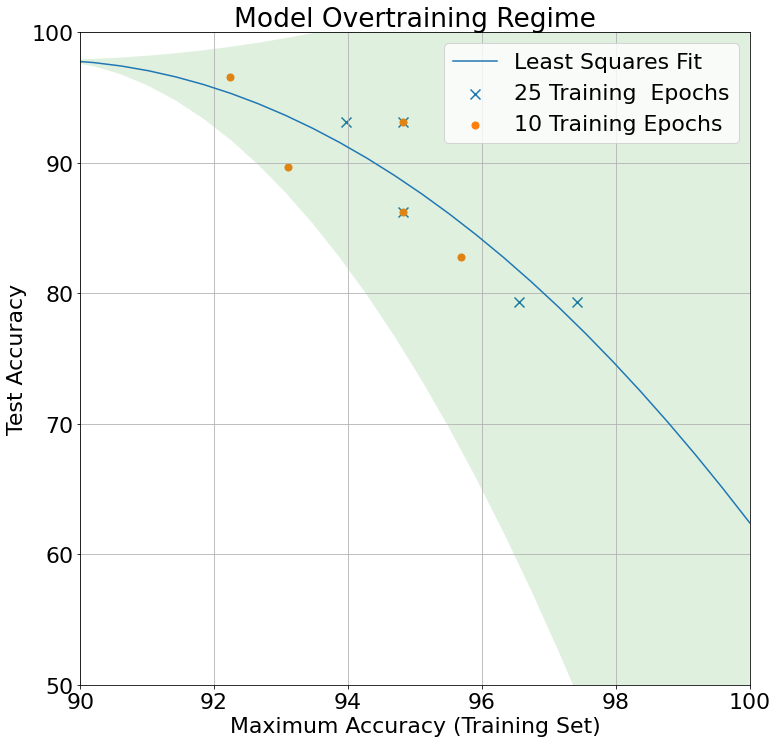

In [164]:

plt.rcParams.update({"font.size":"22"})

plt.figure(figsize=(12,12))
plt.title("Model Overtraining Regime")
plt.scatter(max_acc, model_acc, marker='x', s=100, label='25 Training  Epochs')
plt.scatter(limit_max_acc, limit_model_acc, marker='o', s=50, label='10 Training Epochs')
x_op = np.linspace(80, 100, 50)
plt.plot(x_op, quadratic_fit(x_op, fit[0][0], fit[0][1], fit[0][2]), label='Least Squares Fit')
upper_b = quadratic_fit(x_op, fit[0][0]+np.sqrt(sigmm), fit[0][1], fit[0][2])
lower_b = quadratic_fit(x_op, fit[0][0]-np.sqrt(sigmm), fit[0][1], fit[0][2])
plt.fill_between(x_op, lower_b, upper_b, alpha=0.15)
plt.xlim(90, 100)
plt.ylim(50, 100)
plt.xlabel("Maximum Accuracy (Training Set)")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.legend()
plt.savefig("Overtaining.png")

In [153]:
long_histories = []
short_histories = []
for i, history in enumerate(model_histories):
    long_histories.append(history.history['binary_accuracy'])
    short_histories.append(limit_model_histories[i].history['binary_accuracy'])
long_histories = np.array(long_histories)
short_histories = np.array(short_histories)
long_avg = []
short_avg = []
for i, val in enumerate(long_histories[0,:]):
    long_avg.append(np.mean(long_histories[:,i]))
for i, val in enumerate(short_histories[0,:]):
    short_avg.append(np.mean(short_histories[:,i]))
short_avg = np.array(short_avg)
long_avg = np.array(long_avg)

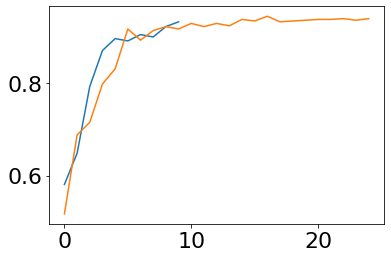

In [156]:
plt.plot(short_avg)
plt.plot(long_avg)


In [162]:
display(np.mean(model_acc))
display(np.std(model_acc))

86.20689749717712

6.168464029627303

In [163]:
display(np.mean(limit_model_acc))
display(np.std(limit_model_acc))

89.65517282485962

4.876597735205404

[0.08972079306840897, 0.9615384340286255]

Epoch 1/10
118/118 [==============================] - 2s 14ms/step - loss: 0.7004 - binary_accuracy: 0.5000
Epoch 2/10
118/118 [==============================] - 1s 7ms/step - loss: 0.4878 - binary_accuracy: 0.7203
Epoch 3/10
118/118 [==============================] - 1s 7ms/step - loss: 0.4387 - binary_accuracy: 0.8644
Epoch 4/10
118/118 [==============================] - 1s 7ms/step - loss: 0.3165 - binary_accuracy: 0.9153
Epoch 5/10
118/118 [==============================] - 1s 7ms/step - loss: 0.2421 - binary_accuracy: 0.9068
Epoch 6/10
118/118 [==============================] - 1s 7ms/step - loss: 0.2235 - binary_accuracy: 0.9068
Epoch 7/10
118/118 [==============================] - 1s 7ms/step - loss: 0.2856 - binary_accuracy: 0.9068
Epoch 8/10
118/118 [==============================] - 1s 7ms/step - loss: 0.3057 - binary_accuracy: 0.9237
Epoch 9/10
118/118 [==============================] - 1s 7ms/step - loss: 0.2595 - binary_accuracy: 0.8898
Epoch 10/10
118/118 [===============

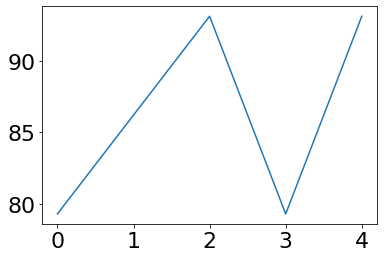

In [158]:
plt.plot(model_acc)

array([[ 0.06300834, -0.01318932,  0.15319477, -0.01177233,  0.08511624,
        -0.07479227, -0.00603211,  0.12662178,  0.234843  ,  0.04213107,
         0.16531779, -0.04818869,  0.03302796,  0.04215921,  0.03799652,
         0.07046741,  0.04987175,  0.11158451,  0.09791929, -0.07826346,
        -0.12052864, -0.0894863 , -0.57600212, -0.00524437,  0.04931872,
        -0.02108645]])

array([0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 1])

array([[0.42399788]], dtype=float32)